In [238]:
import numpy as np
from scipy import interpolate
from tqdm import tqdm, trange
import seaborn as sns
from matplotlib import pyplot as plt
from torchvision.transforms import Resize
from sklearn.metrics import pairwise_distances
import umap
import torch
import os
import json
from barcodes import rtd_from_ats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import wasserstein_distance_nd

In [239]:
def wass(a, b): return wasserstein_distance_nd(a.reshape(32,-1).T, b.reshape(32,-1).T)
def rtd(a, b): return rtd_from_ats(a.reshape(32,32), b.reshape(32,32))

In [134]:
sch, unh = [], []
for i in tqdm(range(32)):
    X, y = [], []
    for f in os.listdir('helm/ats/llamabase7b'):
        if f[:2]!='at' or len(f.split('.'))!=3 or f[-5]=='q': continue
        label = f.split('_')[1][0]
        ats = np.load('helm/ats/llamabase7b/'+f)[:,[i]] 
        crat = pairwise_distances(ats.reshape(ats.shape[0]*ats.shape[1],-1), metric='cosine')
        # crat = pairwise_distances(ats.reshape(32*32,-1))
        # np.save('helm/manifold_graphs/llamabase7b/mg'+f[2:])
        X.append(crat.ravel())
        y.append(int(label))
    X = np.array(X)
    y = np.array(y)
    scs = cross_val_score(KNeighborsClassifier(metric='cosine'), X, y, scoring='roc_auc')
    sch.append(scs.mean())
    unh.append(scs.std())

100%|██████████| 32/32 [02:06<00:00,  3.96s/it]


Text(0, 0.5, 'ROC AUC')

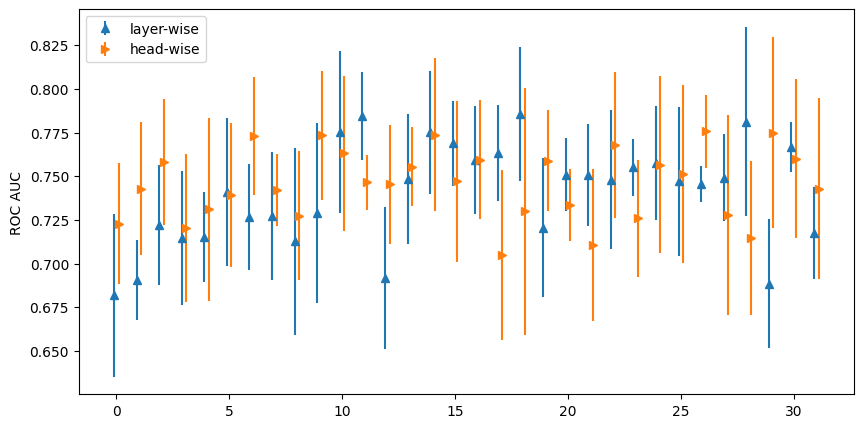

In [145]:
plt.figure(figsize=(10,5))
plt.errorbar(np.arange(32)-0.1,sc,un,fmt='^', label='layer-wise')
plt.errorbar(np.arange(32)+0.1,sch,unh,fmt='>', label='head-wise')
plt.legend(loc='upper left')
plt.ylabel('ROC AUC')

In [110]:
X, y = [], []
for f in tqdm(os.listdir('helm/ats/llamabase7b')):
    if f[:2]!='at' or len(f.split('.'))!=3 or f[-5]=='q': continue
    label = f.split('_')[1][0]
    ats = np.load('helm/ats_wo_tokens/llamabase7b/'+f)[[]] 
    
    def rtd(a, b): return rtd_from_ats(a.reshape(ats.shape[-2],ats.shape[-1]), b.reshape(ats.shape[-2],ats.shape[-1]))
    crat = pairwise_distances(ats.reshape(ats.shape[0]*ats.shape[1],-1), metric='cosine')
    
    # np.save('helm/manifold_graphs/llamabase7b/mg'+f[2:])
    
    X.append(crat.ravel())
    y.append(int(label))
X = np.stack(X)
y = np.array(y)

100%|██████████| 980/980 [00:05<00:00, 164.08it/s]


In [182]:
heads

array([  16,   45,   56,   90,   93,  101,  117,  127,  136,  164,  165,
        205,  214,  223,  227,  231,  244,  250,  251,  260,  262,  267,
        274,  282,  283,  310,  336,  339,  351,  371,  373,  376,  379,
        380,  381,  401,  415,  416,  432,  450,  457,  461,  468,  469,
        477,  495,  501,  506,  511,  514,  549,  589,  607,  622,  626,
        629,  631,  632,  639,  648,  655,  657,  658,  664,  667,  668,
        675,  689,  690,  691,  703,  716,  740,  754,  785,  788,  805,
        818,  833,  837,  854,  862,  863,  865,  895,  898,  901,  918,
        927,  938,  956,  975,  976,  990,  991, 1003, 1009, 1011, 1015])

In [234]:
X, y = [], []
for f in os.listdir('helm/filtration_features/llamabase7b'):
    if f[:2]!='ex' or len(f.split('.'))!=3 or f[-5]=='q': continue
    label = f.split('_')[1][0]
    cff = np.load('helm/filtration_features/llamabase7b/'+f)
    cff = cff.reshape(32*32,15,2)[heads,:]
    ff = np.load('helm/filtration_features/llamabase7b/'+f[8:])
    ff = ff.reshape(32*32,6,6)[heads,:][:,:,[2,3]]
    X.append(np.concatenate((ff,cff), 1).ravel())
    y.append(int(label))
X = np.stack(X)
y = np.array(y)
s = cross_val_score(CatBoostClassifier(verbose=False), X, y, scoring='roc_auc').mean()
s

0.8629150313971742

In [ ]:
X, y = [], []
for f in os.listdir('helm/filtration_features/llamabase7b'):
    if f[:2]!='ex' or len(f.split('.'))!=3 or f[-5]=='q': continue
    label = f.split('_')[1][0]
    cff = np.load('helm/filtration_features/llamabase7b/'+f)
    print(cff)
    cff = cff.reshape(32*32,15,2)[heads,:]
    X.append(np.concatenate((ff,cff), 1).ravel())
    y.append(int(label))
X = np.stack(X)
y = np.array(y)
s = cross_val_score(CatBoostClassifier(verbose=False), X, y, scoring='roc_auc').mean()
s

In [198]:
X, y = [], []
for f in os.listdir('helm/filtration_features/llamabase7b'):
    if f[:2]!='ff' or len(f.split('.'))!=3 or f[-5]=='q': continue
    label = f.split('_')[1][0]
    crat = np.load('helm/filtration_features/llamabase7b/'+f.split('.')[0]+'.q.npy')
    crat = crat.reshape(32*32,6,6)[heads,:][:,[2,3]]
    X.append(crat.ravel())
    y.append(int(label))
X = np.stack(X)
y = np.array(y)
cross_val_score(CatBoostClassifier(verbose=False), X, y, scoring='roc_auc').mean()

0.7808074960753532

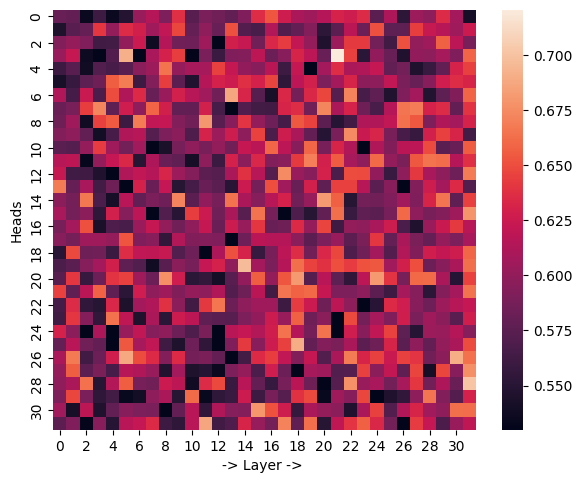

In [247]:
# strength = []
# for i in trange(32*32):
#     X, y = [], []
#     for f in os.listdir('helm/filtration_features_wo_tokens/llamabase7b'):
#         if f[:2]!='ff' or len(f.split('.'))!=3 or f[-5]=='q': continue
#         label = f.split('_')[1][0]
#         # crat = np.load('helm/filtration_features_wo_tokens/llamabase7b/'+f.split('.')[0]+'.q.npy')
#         crat = np.load('helm/filtration_features_wo_tokens/llamabase7b/'+f)
#         # crat = pairwise_distances(qat.reshape(qat.shape[0]*qat.shape[1],-1), metric='cosine')
#         X.append(crat[i%32,i//32,2:4,:,:].ravel())
#         y.append(int(label))
#     X = np.stack(X)
#     y = np.array(y)
#     strength.append(cross_val_score(KNeighborsClassifier(metric='cosine'), X, y, scoring='roc_auc').mean())
plt.figure(figsize=(7.5/1.1,6/1.1))
sns.heatmap(np.array(strength).reshape(32,32), vmin=0.53)
plt.xlabel('-> Layer -> ')
plt.ylabel('Heads')
plt.show()

In [129]:
np.arange(32*32*6*6).reshape(32*32,6*6)[heads][:,[2,3]].ravel()

array([  578,   579,  1622,  1623,  2018,  2019,  3242,  3243,  3350,
        3351,  3638,  3639,  4214,  4215,  4574,  4575,  4898,  4899,
        5906,  5907,  5942,  5943,  7382,  7383,  7706,  7707,  8030,
        8031,  8174,  8175,  8318,  8319,  8786,  8787,  9002,  9003,
        9038,  9039,  9362,  9363,  9434,  9435,  9614,  9615,  9866,
        9867, 10154, 10155, 10190, 10191, 11162, 11163, 12098, 12099,
       12206, 12207, 12638, 12639, 13358, 13359, 13430, 13431, 13538,
       13539, 13646, 13647, 13682, 13683, 13718, 13719, 14438, 14439,
       14942, 14943, 14978, 14979, 15554, 15555, 16202, 16203, 16454,
       16455, 16598, 16599, 16850, 16851, 16886, 16887, 17174, 17175,
       17822, 17823, 18038, 18039, 18218, 18219, 18398, 18399, 18506,
       18507, 19766, 19767, 21206, 21207, 21854, 21855, 22394, 22395,
       22538, 22539, 22646, 22647, 22718, 22719, 22754, 22755, 23006,
       23007, 23330, 23331, 23582, 23583, 23654, 23655, 23690, 23691,
       23906, 23907,

In [ ]:
m = CatBoostClassifier(verbose=100).fit(X,y)
m.get_feature_importanes()

TBB Warning: The number of workers is currently limited to 7. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Learning rate set to 0.008073
0:	learn: 0.6904502	total: 1.1s	remaining: 18m 22s
100:	learn: 0.4949829	total: 1m 5s	remaining: 9m 40s
200:	learn: 0.3845088	total: 2m 9s	remaining: 8m 35s
300:	learn: 0.3125961	total: 3m 13s	remaining: 7m 29s


In [34]:
import pandas as pd
idxs = pd.Series(m.get_feature_importance()).sort_values().tail(100).index.tolist()

In [197]:
X, y = [], []
for f in os.listdir('helm/hd/llamabase7b'):
    if f[-3:]!='npy' or f[-5]=='q': continue
    label = f.split('_')[1][0]
    crat = np.load('helm/hd/llamabase7b/'+f)
    X.append(crat.ravel())
    y.append(int(label))
X = np.stack(X)
y = np.array(y)

cross_val_score(CatBoostClassifier(verbose=False,n_estimators=100), X, y, scoring='roc_auc').mean()

0.8554601648351647

In [199]:
X, y = [], []
for f in os.listdir('helm/hd/llamabase7b'):
    if f[-3:]!='npy' or f[-5]=='q': continue
    label = f.split('_')[1][0]
    crat = np.load('helm/hd/llamabase7b/'+f.split('.')[0]+'.q.npy')
    X.append(crat.ravel())
    y.append(int(label))
X = np.stack(X)
y = np.array(y)

cross_val_score(CatBoostClassifier(verbose=False,n_estimators=100), X, y, scoring='roc_auc').mean()

0.768423273155416